In [ ]:
!pip install numpy pandas statsmodels matplotlib seaborn prophet sklearn 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.dynamic_factor_mq import DynamicFactorMQ
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.theta import ThetaModel
from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from prophet import Prophet

try:
  from google.colab import files
  uploaded = files.upload()
  IN_COLAB = True
except:
  IN_COLAB = False

import warnings
warnings.filterwarnings('once')

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


Functions

In [4]:
def sample_data(df, start_date):
  start_date = datetime.strptime(start_date, '%Y-%m-%d')
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def sample_data_with_train_window(df, start_date, train_window_size):
  start_date = datetime.strptime(start_date, '%Y-%m-%d') - timedelta(hours=train_window_size)
  end_date = df.index[-1]
  return df[(df.index >= start_date) & (df.index <= end_date)]

def get_next_window(data, train_window_size, forecast_horizon):
  return data[:train_window_size], data[train_window_size:train_window_size + forecast_horizon]

def forecast_whitebox_model(model, forecast_horizon, model_name):
  model_res = model.fit()

  if "SARIMA" in model_name and "STL" not in model_name:
    return model_res.get_forecast(steps=forecast_horizon).predicted_mean
  else:
    return model_res.forecast(steps=forecast_horizon)
  
def plot_data(df):
  plt.plot(df)
  plt.title('Consumption in dk private households')
  plt.xlabel('Measurements')
  plt.ylabel('Power (kW / charger)')
  plt.show()

Initializing time series

In [7]:
df = pd.read_csv('../Dataset/ConsumptionIndustry.csv' if not IN_COLAB else 'ConsumptionIndustry.csv', sep=';')
df['HourDK'] = pd.to_datetime(df['HourDK'])
df['ConsumptionkWh'] = df['ConsumptionkWh'].str.replace(",", ".").astype(float)
df.index = df['HourDK']

# format data here
df.drop(columns=['HourUTC', 'HourDK', 'MunicipalityNo', 'Branche'], inplace=True)

Runs a model in Sliding Window forecasting style

In [126]:
model_name = 'Thetaasdas'
date_start = '2023-11-01'
window_train_size = 24*7*2 #hours
forecast_horizon = 24 #hours

data = sample_data_with_train_window(df, date_start, window_train_size) # start: date_start - window_train_size, end: last date in df
# plot_data(data)
results = np.array([])
iterations = 0

warnings.filterwarnings("ignore")

while len(data) > window_train_size + forecast_horizon:
  data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)
  model = ThetaModel(data_train, period=24, method="multiplicative")
  predictions = forecast_whitebox_model(model, forecast_horizon, model_name)
  
  results = np.append(results, predictions.values)
  iterations += 1
  data = data.iloc[forecast_horizon:] # move window by forecast_horizon

warnings.filterwarnings("default")

result_table = pd.DataFrame(results)
result_table.index = pd.date_range(start=date_start, periods=forecast_horizon*iterations, freq='H')
result_table.to_csv(f'../Results/Whitebox/Forecasting/{window_train_size}_{forecast_horizon}_{model_name}.csv', header=False)

Models

In [6]:
  # model = SARIMAX(endog = data_train, order = (1, 1, 4), seasonal_order = (1, 1, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
  # model = STLForecast(data_train, SARIMAX, model_kwargs=dict(order=(1, 1, 1), seasonal_order = (1, 1, 1, 12)), period=24)
  # model = ThetaModel(data_train, period=24, method="additive")
  # model = ThetaModel(data_train, period=24, method="multiplicative")
  # model = DynamicFactorMQ(endog=data_train)

In [17]:
date_start = '2023-11-01'
window_train_size = 24*7*2 #hours
forecast_horizon = 24 #hours
data_train, data_test = get_next_window(data, window_train_size, forecast_horizon)

model = ThetaModel(data_train, period=12, method="multiplicative")
model_res = model.fit()
forecast = model_res.forecast(steps=forecast_horizon)
print(forecast)

337    32103.372509
338    31696.641222
339    31604.982444
340    31624.049282
341    33595.929530
342    38815.717544
343    39223.686623
344    38308.110136
345    37183.063240
346    36073.898804
347    34108.046141
348    32525.791400
349    32162.912698
350    31755.417987
351    31663.580186
352    31682.673317
353    33658.199378
354    38887.651127
355    39296.365032
356    38379.081096
357    37251.939265
358    36140.709955
359    34171.206660
360    32586.012642
Name: forecast, dtype: float64


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\forecasting\theta.py:44: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  return DeterministicTerm._extend_index(index, steps)


Plot of forecasts

KeyError: 'Prediction'

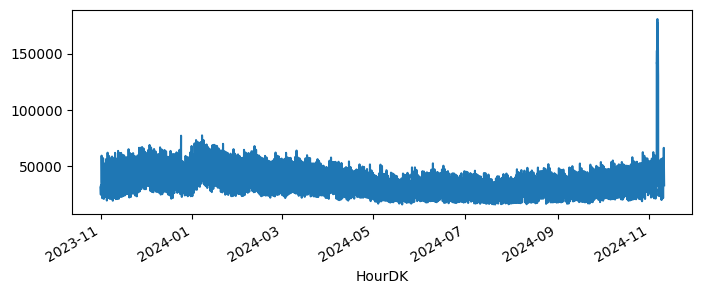

In [11]:
date_start = '2023-11-01'
data = sample_data(df, date_start) 
# prediction_Theta_additive = pd.read_csv('../Results/Whitebox/Forecasting/336_24_ThetaModel_additive.csv', header=None, index_col=0, names=['Prediction'])
# prediction_Theta_additive.index = pd.to_datetime(prediction_Theta_additive.index)
# prediction_Theta_multiplicative = pd.read_csv('../Results/Whitebox/Forecasting/336_24_ThetaModel_multiplicative.csv', header=None, index_col=0, names=['Prediction'])
# prediction_Theta_multiplicative.index = pd.to_datetime(prediction_Theta_multiplicative.index)
# prediction_DynamicFactorMQ = pd.read_csv('../Results/Whitebox/Forecasting/336_24_DynamicFactorMQ.csv', header=None, index_col=0, names=['Prediction'])
# prediction_DynamicFactorMQ.index = pd.to_datetime(prediction_DynamicFactorMQ.index)

fig, ax = plt.subplots(figsize=(8, 3))
data['ConsumptionkWh'].plot(ax=ax, label='True')
# prediction_Theta_additive['Prediction'].plot(ax=ax, label='Theta_additive')
# prediction_Theta_multiplicative['Prediction'].plot(ax=ax, label='Theta_multiplicative')
# prediction_DynamicFactorMQ['Prediction'].plot(ax=ax, label='DynamicFactorMQ')
ax.set_title('Predictions')
ax.legend()

Evaluate algorithm performance

In [127]:
# def evaluate(prediction, name):
#     print(f"-- {name} --")
#     print(f"mse: {mean_squared_error(data, prediction)}") #penalizes larger errors more
#     print(f"rmse: {root_mean_squared_error(data, prediction)}")

# data = sample_data(df, date_start) 

# evaluate(prediction_Theta_additive['Prediction'], 'Theta_additive')
# evaluate(prediction_Theta_multiplicative['Prediction'], 'Theta_multiplicative')
# evaluate(prediction_DynamicFactorMQ['Prediction'], 'DynamicFactorMQ')


-- Theta_additive --
mse: 95222466.90650392
rmse: 9758.199982912009
-- Theta_multiplicative --
mse: 95911480.46870957
rmse: 9793.440685923899
-- DynamicFactorMQ --
mse: 129933503.2759868
rmse: 11398.837803740644
